<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Laboratorio 3</h2>
    <h2> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> 2025-1</h2>
</center>

In [1]:
!pip install pillow

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

# Laboratorio 3: Modelado de desenfoque en imágenes mediante operadores lineales
# Funciones

Para la implementación de las preguntas, considere que **solo** tiene a su disposición las siguientes funciones:
* **np.linalg.svd(A, full_matrices=False)**: Calcula la descomposición en valores singulares (SVD) de la matriz **A**. Devuelve tres matrices: **U**, **Σ** (valores singulares) y **$V^\top$** tales que $A = U \Sigma V^\top$.
Por ejemplo `A = np.array([[1, 2], [3, 4], [5, 6]])`
le aplicamos la descomposicion svd `U, S, VT = np.linalg.svd(A, full_matrices=False)`
los output correspondientes serian:
    ```python
    U: [[-0.2298477   0.88346102]
        [-0.52474482  0.24078249]
        [-0.81964194 -0.40189603]]
    S: [9.52551809 0.51430058]
    VT: [[-0.61962948 -0.78489445]
         [-0.78489445  0.61962948]]

* **np.argsort(a)**: Devuelve los índices que ordenarían un array. Si el array es unidimensional, los índices corresponden al orden ascendente de los elementos. Para arrays multidimensionales, se aplica el ordenamiento aplanando el array primero.
`np.argsort([3, 1, 2])` devolvería `[1, 2, 0]`, ya que el índice del menor elemento osea el (1) es la posicion 1, seguido por el índice del siguiente menor elemento (2), que esta en la posicion 2, y finalmente el índice del mayor elemento (3), que esta en la posicion 0.
* **np.ravel(a)**: Devuelve una vista aplanada del array de entrada **a**. Si el array es multidimensional, se convierte en un array unidimensional sin copiar los datos siempre que sea posible.Por ejemplo, si se construye la matriz `a = np.array([[1,2],[3,4]])`, y se le aplica `np.ravel(a)` se obtiene `[1 2 3 4]`.

* **np.zeros_like(a)**: Devuelve un array de ceros con la misma forma y tipo que el array de entrada **a**. Esto es útil para inicializar matrices o arrays con valores nulos mientras se conserva la estructura del array original.  
Por ejemplo, si se construye la matriz `a = np.array([[1, 2], [3, 4]])`, y se le aplica `np.zeros_like(a)` se obtiene `array([[0, 0],[0, 0]])`

* **np.linalg.norm(x, ord='fro')**: Calcula la norma de Frobenius de una matriz **x**, que es la raíz cuadrada de la suma de los cuadrados de sus elementos. Es útil para medir la magnitud de una matriz o calcular errores relativos entre matrices.  
Por ejemplo, si se construye la matriz `x = np.array([[1, 2], [3, 4]])`, y se le aplica `np.linalg.norm(x, ord='fro')`, se obtiene el resultado `5.477225575051661`, ya que:  
$\sqrt{1^2 + 2^2 + 3^2 + 4^2} = \sqrt{30} \approx 5.477$.

* **np.diag(a)**: Esta función crea una matriz diagonal a partir de un vector plano (unidimensional). Los elementos del vector se colocan en la diagonal principal de una nueva matriz cuadrada, y el resto de los elementos se rellenan con ceros. Por ejemplo, si `a = np.array([1, 2, 3])`, entonces `np.diag(a)` produce la matriz:
    ```python
        [[1,0,0]
         [0,2,0]
         [0,0,3]]


In [3]:
# Construcción de operadores de 'desenfoque'
def blur_operator(m, n, bl=1):
    """
    Genera los operadores de convolución 1-D empleados en el paper.

    inputs:
    ----------
    m, n : int
        Dimensiones de la imagen (filas = m, columnas = n).
    bl : {1, 2}
        1  → blur simétrico  (σ_r = σ_c = 0.01)
        2  → blur asimétrico (σ_r = 0.02, σ_c = 0.01)

    outputs:
    --------
    Ac : ndarray (m, m)
        Matriz Toeplitz que difumina horizontalmente (columnas).
    Ar : ndarray (n, n)
        Matriz Toeplitz que difumina verticalmente (filas).
    """

    # --- 1. Parámetros ----------------------------------------------------
    sigmac = 0.01
    sigmar = 0.02 if bl == 2 else sigmac
    # --- 2. Nucleos 1-D ---------------------------------------------------
    c_pos = np.linspace(0, 1, m)          # coordenadas normalizadas
    r_pos = np.linspace(0, 1, n)

    c = np.exp(-0.5 * (c_pos / sigmac) ** 2)
    r = np.exp(-0.5 * (r_pos / sigmar) ** 2)

    # umbral 1e-4
    c[c < 1e-4] = 0.0
    r[r < 1e-4] = 0.0

    # normalización: división por (2·sum − valor central)
    c /= (2 * c.sum() - c[0])
    r /= (2 * r.sum() - r[0])

    # --- 3. Matrices Toeplitz --------------------------------------------
    Ac = toeplitz(c)          # (m × m)
    Ar = toeplitz(r)          # (n × n)
    return Ac, Ar



# Introducción al Laboratorio 3

En este laboratorio, exploraremos el modelado y la restauración de imágenes afectadas por desenfoque y ruido, utilizando herramientas matemáticas avanzadas como la descomposición en valores singulares (SVD). El objetivo principal es comprender cómo los operadores lineales, como las matrices de convolución, pueden simular el desenfoque en imágenes y cómo estas mismas herramientas pueden ser utilizadas para restaurar imágenes degradadas.

El proceso de desenfoque se modela mediante matrices Toeplitz que representan convoluciones gaussianas en las direcciones horizontal y vertical. Estas matrices, combinadas con ruido gaussiano, generan una imagen degradada que será el punto de partida para los algoritmos de restauración.

A lo largo del laboratorio, se implementarán técnicas basadas en SVD truncado para reconstruir la imagen original a partir de la imagen desenfocada y ruidosa. Además, se analizará el impacto de los valores singulares en la calidad de la reconstrucción, seleccionando los valores más relevantes para minimizar el error relativo entre la imagen original y la reconstruida.

# Proceso de desenfoque y degradación de la imagen

Utilizamos un desenfoque Gaussiano **asimétrico** para lograr desenfocar la imagen. **En este caso se hará un desenfoque solo con $A_c$**, es decir, la imagen perturbada se obtendrá de la siguiente forma:
$$
    B_{\text{data}} = \underbrace{A_c\,X_{\text{true}}}_{\displaystyle{B_{\text{true}}}} + \Xi
$$
donde $\Xi$ es el ruido agregado.
Para la caracterización del ruido $\Xi$  se utilizará el SNR (_signal-to-noise-ratio_), el cual se define de la siguiente forma,
$$
SNR = 10 \cdot \log_{10} \left( \frac{ \| B_{\text{true}} \|_F^2 }{ \| \Xi \|_F^2 } \right)
$$
la cual se especificará más adelante.

**NOTAR que este desenfoque propuesto es una versión reducida del presentado en el contexto del laboratorio, por lo cual debe tomar ventaja de esta simplificación significativa.**

A continuación se presenta el **forward problem**, es decir la construcción de una imagen degradada a partir de una imagen detallada.
Este procedimiento ya fue incluido en el contexto también.

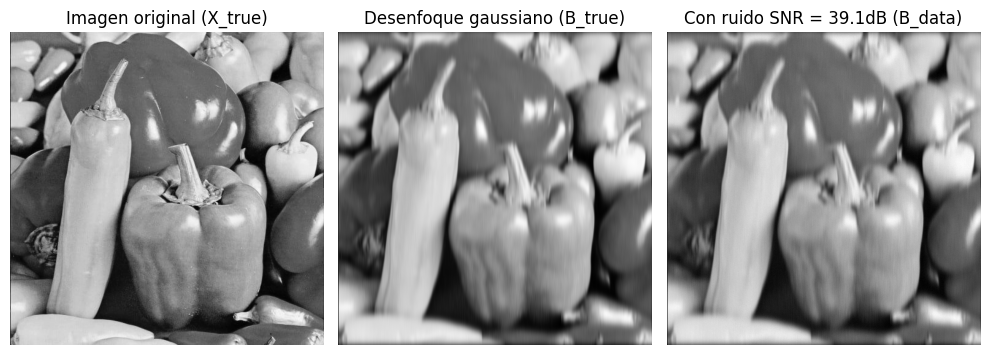

In [6]:
# Añadiendo ruido y desenfoque a la imagen
# -------------------------------
# Cargar imagen original y convertir a escala de grises
img = Image.open("img.jpg").convert("L")
img = img.resize((512, 512))
X_true = np.array(img) / 255.0  # Imagen original normalizada

# -------------------------------
# Creando la matriz de desenfoque gaussiano asimétrico
Ac, _ = blur_operator(512, 512, bl=1)
# -------------------------------
# Aplicando el desenfoque gaussiano a la imagen original
B_true = Ac @ X_true
# Añadiendo ruido gaussiano a la imagen desenfocada
E = np.load("ruido.npy")
B_data = B_true + E
snr_db = 10*np.log10(np.power(np.linalg.norm(B_true,'fro')/np.linalg.norm(E),2.))
# -------------------------------
# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_true, cmap='gray')
plt.title("Imagen original (X_true)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(B_true, cmap='gray')
plt.title("Desenfoque gaussiano (B_true)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(B_data, cmap='gray')
plt.title(f"Con ruido SNR = {snr_db:.1f}dB (B_data)")
plt.axis('off')

plt.tight_layout()
plt.show()

A modo referencial, se recuerda que la relación entre la imagen degradada ($B_{\text{data}}$) y la imagen original ($X_{\text{true}}$) satisface la siguiente ecuación,
$$
    B_{\text{data}} = A_c\,X_{\text{true}} + \Xi
$$

## Proceso de truncamiento para limpiar el ruido y el desenfoque de la imagen $B_{\text{data}}$

Sea $A_c $ la matriz de convolución por columna, multiplicada por la izquierda a la imagen.

Construyendo la factorización SVD de $A_c$ obtenemos:
$$
A_c = U_c\,\Sigma_c\,V_c^\top
$$
Para obtener la reconstrucción $X_{\text{recon}}$ de la imagen original $X_{\text{true}}$, se necesita construir $A_{c,\text{trunc}}^{-1}$, la cual se obtendrá por medio de la SVD anterior.
Es decir, definimos la reconstrucción de la siguiente forma
$$
X_{\text{recon}} = A_{c,\text{trunc}}^{-1}\,B_{\text{data}}
$$
Utilizando la SVD de $A_c$, podemos obtener $A_{c,\text{trunc}}^{-1}$ de la siguiente forma,
$$
X_{\text{recon}} = V_c\,\widehat{\Sigma}_c\,U_c^\top\,B_{\text{data}}.
$$
donde,
$$
\left(\widehat{\Sigma}_c\right)_{i,j} =
\begin{cases}
    \frac{1}{(\sigma_c)_i} &  \text{ si $(\sigma_c)_i> \alpha$ y $i=j$}, \\
    0 & \text{en todo otro caso},
\end{cases}
$$
donde $i,j\in \{1,2,3,\dots,n\}$, es decir se indexan desde $1$.
**Esto significa que solo seleccionaremos los valores singulares $\sigma_c$ mayores a $\alpha$ para poder truncar el operador.**
Así, $\widehat{\Sigma}_c$ solo conserva la información de los valores singulares significativos, eliminando el efecto de los valores singulares pequeños asociados principalmente al ruido.
Ahora, por conveniencia, se define la siguiente matriz,
$$
\widehat{B} = U_c^\top\,B_{\text{data}}
$$
Así, la reconstrucción queda:
$$
X_{\text{recon}} = V_c \left( \widehat{\Sigma}_c\,\widehat{B} \right)
$$

### Pregunta 1.1 (20 pts)

En este pregunta se debe construir y retornar la matriz $\widehat{\Sigma}_c$ definida anteriormente.
Se recibe como parámetros un vector con los valores singulares de $A_c$ y el umbral $\alpha$.

In [8]:
def matriz_Sigma_hat(sigma,alpha):
    """
    input:
    sigma : array(n)
        Vector sigma (contiene los valores sigulares).
    alpha : float
        Tolerancia para seleccionar los valores singulares.
    output:
    Sigma_hat: ndarray (n, n)
        Devuelve una matriz con el reciproco de los valores singulares mayores a alpha.
    """
    #--- acá va su código aquí ----
    inv_sigma= np.zeros_like(sigma)
    inv_sigma[sigma>alpha]=1/sigma[sigma>alpha]
    Sigma_hat=np.diag(inv_sigma)
    #------------------------------
    return Sigma_hat


[[0.2 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.5]]


### Pregunta 1.2 (40 pts)
Implemente la restauración de la imagen $B_{\text{data}}$ usando el procedimento explicado anteriormente, cuando solo se le aplica un desenfoque por columnas.

In [9]:
def restaurar_imagen(B_data,Ac,alpha):
    """
    input:
    B_data : ndarray (m, n)
        Imagen borrosa y ruidosa (con ruido gaussiano).
    Ac : ndarray (m, m)
        Matriz Toeplitz que difumina horizontalmente (columnas).
    alpha : float
        Umbral para seleccionar los valores singulares.
    output:
    X_recon : ndarray (m, n)
        Imagen reconstruida (con ruido y desenfoque).
    """
    #--- acá va su código aquí ----
    U,S,VT=np.linalg.svd(Ac)
    Sigma_gorrito= matriz_Sigma_hat(S,alpha)
    X_recon= VT.T @ Sigma_gorrito @ U.T @ B_data
    #------------------------------
    return X_recon

mostrar en pantalla la imagen reconstruida

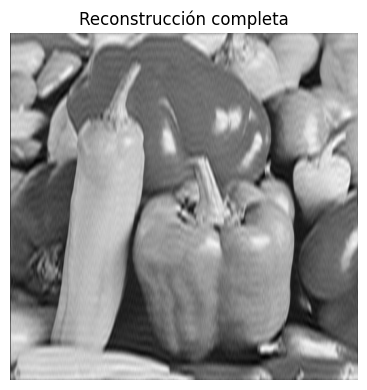

In [10]:
### Solo debe ejecutar esta celda
X_recon = restaurar_imagen(B_data, Ac,alpha=0.08)

plt.figure(figsize=(5,4))
plt.imshow(X_recon, cmap='gray')
plt.axis('off')
plt.title('Reconstrucción completa')
plt.tight_layout()
plt.show()

# 2. $\alpha$ óptimo para la reconstrucción mediante MRE.

Dado un conjunto de datos de imágenes difuminadas y con ruido almacenadas en la carpeta `imgResBlur/` y sus imágenes originales `imgRes/` correspondiente, es posible calcular el $\alpha$ óptimo para la restauración de imágenes con ruido mediante la minimización del MRE,  el cual corresponde a:
$$
\Phi_{MRE}(\alpha) = \frac{1}{N} \sum^{N}_{n=1} \mathcal{E}(n,\alpha),
$$
donde $\mathcal{E}(n,k)$ corresponde al error relativo absoluto de la $n$-ésima imágen en comparación con la reconstrucción de la $n$-ésima imagen original utilizando $\alpha$ como umbral. $N$ corresponde a la cantidad de imágenes en el dataset.

### Utils
Función para cargar los datos y variables globales.

In [11]:
def loadData(directorio='imgRes/', batch=10):
    try:
        archivos = os.listdir(directorio)
        archivos = sorted(archivos)
    except FileNotFoundError:
        print(f"El directorio {directorio} no existe")
        return 0

    i = 0
    data = []
    for imagen in archivos:
        img = Image.open(directorio+imagen)
        data.append(np.array(img))

        i += 1
        if i == batch:
            break
    data = np.stack(data)
    return data

#Variables globales:
imgShape = 128
Acm, _ = blur_operator(imgShape, imgShape, bl=1)

#Cargar ground Truth
imgsTrue = loadData(directorio='imgRes/', batch=100)

#Cargar imágenes con blur
imgsBlur = loadData(directorio='imgResBlur/', batch=100)

El directorio imgRes/ no existe
El directorio imgResBlur/ no existe


### Pregunta 2.1 (10 pts)
Construya la función que calcule el **error relativo** entre la imagen original $Y$ y su respectiva reconstrucción $X$, es decir debe obtener la siguiente expresión,
$$
    err = \dfrac{\|X-Y\|_{\text{F}}}{\|Y\|_{\text{F}}},
$$
donde $\|\cdot\|_{\text{F}}$ corresponde a la norma matricial de Frobenious.

In [12]:
def error_relativo(X, Y):
    """
    input:
    X: ndarray
        Imagen reconstruida
    Y: ndarray
        Imagen original
    output:
    err : float
        Error relativo absoluto
    """
    #--- acá va su código aquí ----
    num= np.linalg.norm(X-Y,'fro')
    den= np.linalg.norm(Y,'fro')
    err= num/den
    #------------------------------
    return err

El siguiente código obtiene el MRE pero requiere la implementación previa de `restaurar_imagen` y `error_relativo`.

In [17]:
def getMRE(B, T, Ac, alpha):
    """
    input:
    B : ndarray
        Lista de imágenes borrosas y ruidosas,
            donde B[i] es la i-ésima imagen degradada
    T: ndarray
        Lista de imágenes originales,
            donde T[i] es la i-ésima imagen original
    Ac: ndarray
        Matriz Toeplitz que difumina horizontalmente (columnas).
    alpha: float
        tolerancia entregada para reconstruir las imágenes.
    output:
    mre : ndarray
        Valor del mre.
    """
    mre = 0
    for n in range(T.shape[0]):
        X_rest = restaurar_imagen(B[n], Ac, alpha)
        mre += error_relativo(X_rest, T[n])
    mre /= T.shape[0]
    return mre

## Pregunta 3
Ejecute la celda.

**Nota: Se demora menos de 1 minuto.**

In [18]:
alphas = np.logspace(-4, 2, 50, base=10,dtype=float)
fun_mre = lambda alpha: getMRE(B=imgsBlur, T=imgsTrue, Ac=Acm, alpha=alpha)
fun_mre_vectorized = np.vectorize(fun_mre)
res = fun_mre_vectorized(alphas)

plt.figure()
plt.loglog(alphas, res, '.', label='mre')
plt.grid(True)
plt.ylabel('$\\Phi_{MRE}(\\alpha)$')
plt.xlabel('$\\alpha$')
plt.legend()
plt.show()

AttributeError: 'int' object has no attribute 'shape'

### Pregunta 3.1 (20 pts)
Explique a qué se debe el comportamiento en los extremos del dominio del experimento numérico anterior.

----------------------------------------------------------------------
**Respuesta:** Cuando analizamos la curva del error en función de $\alpha$, observamos que el error crece tanto si $\alpha$ es muy pequeño como si es muy grande. Si tenemos que es muy pequeño se da el siguiente caso:
- Se incluyen todos los valores singulares, incluso los más pequeños.
- Los valores singulares pequeños son muy sensibles al ruido.
- Al invertirlos (usando $1/\sigma_i$), se amplifica fuertemente el ruido presente en la imagen degradada.
- Como resultado, la reconstrucción incorpora mucho ruido amplificado, y el error crece.

En caso de que sea muy grande se da que:
- Se eliminan muchos valores singulares importantes, incluyendo algunos que contienen información útil de la imagen original.
- Esto hace que la reconstrucción pierda detalle y precisión, generando una imagen muy suavizada o borrosa.
- Por tanto, el error también aumenta.
Esto nos quiere decir que existe un valor de $\alpha$ óptimo  que equilibra la eliminación del ruido y la preservación de la información importante. Fuera de ese rango, ya sea por ruido amplificado o por pérdida de detalle, el error de reconstrucción se vuelve elevado.

----------------------------------------------------------------------

### Pregunta 3.2 (10 pts)
El fundamento de hacer el experimento numérico anterior es obtener una umbral $\alpha$ óptimo y aplicarlo a imágenes degradadas, y que no se tiene acceso a su imagen original.
En base al gráfico anterior, escoja un valor óptimo de umbral $\alpha$ y **justifique** su elección.

**NOTA: En la siguiente celda debe incluir el valor de $\alpha$ elegido para que pueda ver su resultado.**

--------------------------------------------------------
**Respuesta:** El valor más conveniente de $\alpha$ es aquel que minimiza la función de error relativo promedio $\Phi_{\text{MRE}}(\alpha)$.

Este valor representa el mejor equilibrio entre:
- Eliminar los valores singulares pequeños (que amplifican el ruido)
- Conservar suficientes componentes para reconstruir detalles relevantes de la imagen

Al observar el gráfico de $\Phi_{\text{MRE}}(\alpha)$, identificamos que el mínimo se encuentra aproximadamente en 0.7

--------------------------------------------------------

In [ ]:
#----coloque el valor de la tolerancia aquí----
alpha_optimo =  0.7
#----------------------------------------------
print(alpha_optimo)

NameError: name 'alpha_optimo' is not defined

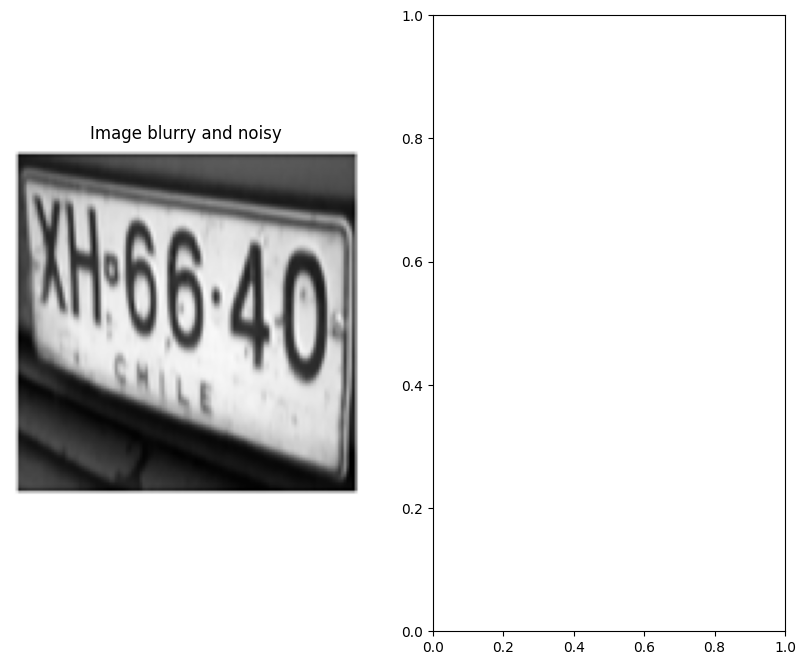

In [19]:
img = Image.open("end_A.jpg").convert("L")
img=img.resize((128, 128))
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Image blurry and noisy")
plt.axis('off')

plt.subplot(1, 2, 2)
img_res = restaurar_imagen(img, Acm, alpha_optimo)
plt.imshow(img_res, cmap='gray')
plt.title("Image noisy and blurry fixed")
plt.axis('off')
plt.tight_layout()
plt.show()